In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.tools.visualization import circuit_drawer
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import datasets
from sklearn.preprocessing import normalize, StandardScaler

/Users/i335439/Desktop/QML/venv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


## Iris dataset

Introduced by famous British statistician **Sir Ronald Fisher** (known as one of the founders of population genetics).

<td> <img src="figures/fisher.png" alt="Drawing" style="width: 250px;"/> </td>

Dataset presented in 1936 paper *"The use of multiple measurements in taxonomic problems"*.  Edgar Anderson collected 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

<table><tr>
<td> <img src="figures/iris.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="figures/versicolor.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="figures/virginica.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>


In [2]:
iris = datasets.load_iris()

In [3]:
irisData = pd.DataFrame({_[0]: iris.data[:, _[1]] for _ in zip(iris.feature_names, range(len(iris.feature_names)))})
labelNames = {_[0]: _[1] for _ in zip(range(len(iris.target_names)), iris.target_names)}
irisData['label'] = [labelNames[_] for _ in iris.target]

In [4]:
setosa = irisData[irisData['label'] == 'setosa']
versicolor = irisData[irisData['label'] == 'versicolor']
virginica = irisData[irisData['label'] == 'virginica']

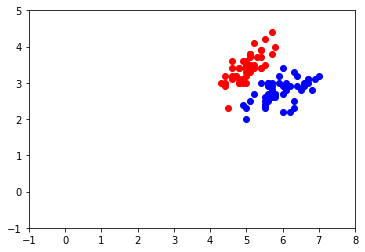

In [5]:
fig, ax = plt.subplots()
ax.scatter(versicolor['sepal length (cm)'], versicolor['sepal width (cm)'], color='b')
ax.scatter(setosa['sepal length (cm)'], setosa['sepal width (cm)'], color='r')
ax.set_xlim([-1, 8]); ax.set_ylim([-1, 5]); ax.set_aspect('equal')

In [6]:
selectedData = irisData[irisData['label'].isin(['versicolor', 'setosa'])]
selectedData = selectedData[['sepal length (cm)', 'sepal width (cm)', 'label']]

scaler = StandardScaler().fit(selectedData[['sepal length (cm)', 'sepal width (cm)']])
normalizedData = scaler.transform(selectedData[['sepal length (cm)', 'sepal width (cm)']])
normalizedData = normalize(normalizedData)

normalizedData = pd.DataFrame({'sepal length (cm)': normalizedData[:, 0],
                               'sepal width (cm)': normalizedData[:, 1],
                               'label': selectedData['label']})

In [7]:
normVersicolor = normalizedData[normalizedData['label'] == 'versicolor']
normSetosa = normalizedData[normalizedData['label'] == 'setosa']

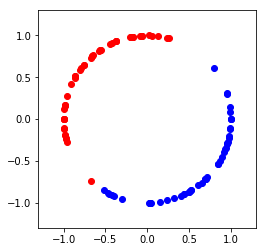

In [8]:
fig, ax = plt.subplots()
ax.scatter(normVersicolor['sepal length (cm)'], normVersicolor['sepal width (cm)'], color='b')
ax.scatter(normSetosa['sepal length (cm)'], normSetosa['sepal width (cm)'], color='r')
ax.set_xlim([-1.3, 1.3]); ax.set_ylim([-1.3, 1.3]); ax.set_aspect('equal')

## Samples selected in the EPL article

In [9]:
normalizedData.iloc[[33, 85, 28, 55]]

,sepal length (cm),sepal width (cm),label
33,0.019647,0.999807,setosa
85,0.795134,0.606434,versicolor
28,-0.557585,0.830120,setosa
55,0.496113,-0.868258,versicolor


# Nearset neighbor classifier

We are using 2 training vectors:
$$
\begin{align}
x_0 = (0.019647, 0.999807) \quad & y_0 = 0 \quad (\text{setosa}) \\
x_1 = (0.795134, 0.606434) \quad & y_1 = 1 \quad (\text{versicolor})
\end{align}
$$

and we look for (euclidean distance) nearest neighbor to a new vector $x^\prime$.  In other words, classificication is achieved by

<img src="figures/classifier.png" alt="Drawing" style="width: 600px;"/> </td>

**(Epanechnikov kernel)**

In [10]:
x0 = [0.019647, 0.999807]      # class 0
x1 = [0.795134, 0.606434]      # class 1

xprime = [-0.557585, 0.830120] # suppposed to be in class 0
#xprime = [0.496113, -0.868258] # suppposed to be in class 1

## Initializing the quantum circuit

In [11]:
numbQubits = 4
q, c = QuantumRegister(numbQubits), ClassicalRegister(numbQubits)
circuit = QuantumCircuit(q, c)

## State preparation

In [12]:
theta1 = np.arctan2(x1[1], x1[0])                 # angles for state encoding
thetaPrime = 2 * np.arctan2(xprime[1], xprime[0]) # angles for state encoding

circuit.h(q[0])
circuit.h(q[1])

circuit.cu3(thetaPrime, 0, 0, q[0], q[2])

circuit.x(q[0])
circuit.ccx(q[0], q[1], q[2])
circuit.x(q[1])
circuit.ccx(q[0], q[1], q[2])

circuit.cu3(- theta1, 0, 0, q[1], q[2])
circuit.ccx(q[0], q[1], q[2])
circuit.cu3(theta1, 0, 0, q[1], q[2])

circuit.cx(q[1], q[3])

At this stage we have achieved the following state preparation

<img src="figures/statePrep.png" alt="Two magnets" style="width: 800px;"/>

## The algorithm: a single Hadamard gate

In [13]:
circuit.h(q[0])

circuit.measure(q, c)

Thanks to the Hadamar gate we have now a superposed state defined by:

<img src="figures/afterHadamard.png" alt="Two magnets" style="width: 800px;"/>
<img src="figures/notation.png" alt="Two magnets" style="width: 400px;"/>

## Visualizing the circuit

/Users/i335439/Desktop/QML/venv/lib/python3.6/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)
WARNING Unable to compile latex. The output from the pdflatex command can be found in latex_error.log


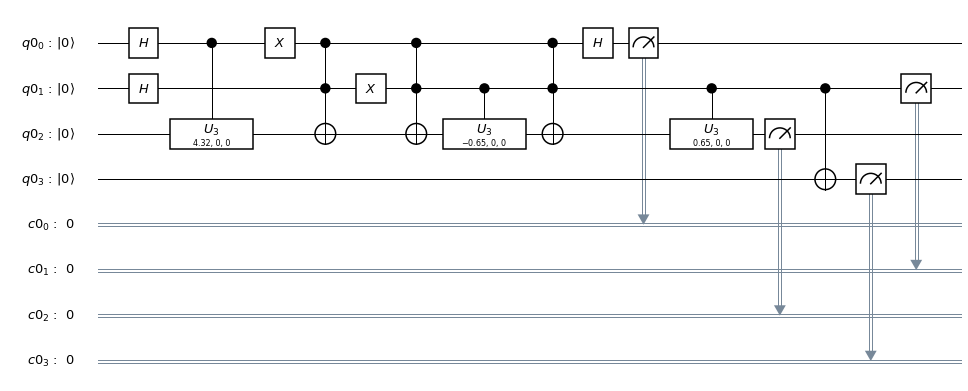

In [14]:
circuit_drawer(circuit)

## Execute on quantum computer


<table><tr>
<td> <img src="figures/ibmWide.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="figures/chip.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

In [15]:
shots = 1000

qmlResult = execute(circuit, backend = BasicAer.get_backend('qasm_simulator'), shots = shots)
qmlCounts = qmlResult.result().get_counts(circuit)

qmlCounts

/Users/i335439/Desktop/QML/venv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


{'0101': 2,
 '1010': 9,
 '0100': 390,
 '1110': 292,
 '1011': 226,
 '0001': 37,
 '0000': 34,
 '1111': 10}

## Conditional measurement predicated to value of ancilla qubit

In [16]:
conditionalCounts = {_: qmlCounts[_] for _ in qmlCounts.keys() if _[3] == '0'}

conditionalCounts

{'1010': 9, '0100': 390, '1110': 292, '0000': 34}

<img src="figures/final.png" alt="Two magnets" style="width: 800px;"/>

In [17]:
class0Counts = [qmlCounts[_] for _ in conditionalCounts if _[2] == '0']
class1Counts = [qmlCounts[_] for _ in conditionalCounts if _[2] == '1']

print(class0Counts > class1Counts)

True
